In [ ]:
! pip install kaggle
! pip install contractions
! pip install langdetect

# install this packages to avoid errors with versions
! pip install git+https://github.com/huggingface/transformers.git
! pip install tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=2dc082fb206cd81d98a8e6f70e90b7444de06257a3f9f010f8e80256b0e5f4b7
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-5b5so64b
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-5b5so64b
  Resolved https://github.com/huggingface/transformers.git to commit 481a95781404e48b1c80940be17e8279dec82fe8
  Installing build dependencies ... done
  Getting requirements to build wheel ... do

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Download data from fake news competition**

In [ ]:
from google.colab import files

# select your kaggle API token
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle competitions download -c 'fake-news'
!ls

 99% 46.0M/46.5M [00:01<00:00, 42.6MB/s]
100% 46.5M/46.5M [00:01<00:00, 27.7MB/s]
drive  fake-news.zip  kaggle.json  sample_data


In [ ]:
import zipfile
import pandas as pd

with zipfile.ZipFile('fake-news.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(20800, 5)
(5200, 4)


# **Data Preprocessing**

In [ ]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [ ]:
# Verify null fields
train[train.text.isna()].head(5)

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1


## Null values treatment

In [ ]:
# Train dataset
train["author"] = train["author"].fillna("")
train["title"] = train["title"].fillna("")
train["text"] = train["text"].fillna("")
print('Train sum null values: ',train.isna().sum().sum())

# Test dataset
test["author"] = test["author"].fillna("")
test["title"] = test["title"].fillna("")
test["text"] = test["text"].fillna("")
print('Train sum null values: ', test.isna().sum().sum())

Train sum null values:  0
Train sum null values:  0


In [ ]:
# create new field input to model
train["input_text"] = train["author"] + ' ' + train["title"] + ' ' + train["text"]
test["input_text"] = test["author"] + ' ' + test["title"] + ' ' + test["text"]

In [ ]:
train.head()

,id,title,author,text,label,input_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


## Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

([<matplotlib.patches.Wedge at 0x7ac480b53e20>,
 [Text(-1.149997783093558, -0.0022580699507423834, 'Fake'),
  Text(1.149997783093558, 0.002258069950741731, 'True')],
 [Text(-0.649998746965924, -0.0012763004069413467, '50.1%'),
  Text(0.649998746965924, 0.0012763004069409785, '49.9%')])

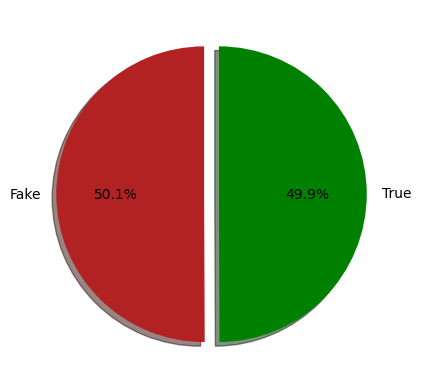

In [ ]:
# Data balanced

label_size = [train['label'].sum(),len(train['label'])-train['label'].sum()]
plt.pie(label_size,explode=[0.05,0.05],colors=['firebrick','green'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [ ]:
# news language
from langdetect import detect

news_lang_detected = train["input_text"].apply(detect)
news_lang_detected_test = test["input_text"].apply(detect)

In [ ]:
df_news_lang_detected = pd.DataFrame({"lang" : news_lang_detected, "label": train["label"]})
df_news_lang_detected.value_counts()

lang   label
en     0        10386
       1         9876
ru     1          156
es     1          141
de     1           97
fr     1           70
ar     1           19
it     1            7
pt     1            7
tr     1            7
no     1            6
nl     1            6
hr     1            4
af     1            3
ca     1            3
el     1            2
sv     1            2
cy     1            1
da     1            1
pl     1            1
fr     0            1
so     1            1
sw     1            1
tl     1            1
zh-cn  1            1
Name: count, dtype: int64

In [ ]:
news_lang_detected_test.value_counts()

input_text
en    5061
ru      47
es      32
de      23
fr      15
it       5
pt       4
ar       3
id       3
tr       3
el       2
no       1
tl       1
Name: count, dtype: int64

In [ ]:
# Token length

from typing import Dict, List

def get_token_counts(dataset: pd.DataFrame) -> Dict:
    token_counts = {"test": []}
    for _, row in dataset.iterrows():
        token_count = len(row["input_text"].split(" "))
        # print(token_count)
        if "label" in list(dataset.columns):
            # print(list(dataset.columns))
            if row["label"] not in token_counts:
                token_counts[row["label"]] = [token_count]
                # print('token counts if', token_counts)
            else:
                token_counts[row["label"]].append(token_count)
                # print('token counts else', token_counts)
        else:
            token_counts["test"].append(token_count)
    return token_counts

In [ ]:
train_num_tokens = get_token_counts(train.copy())
test_num_tokens = get_token_counts(test.copy())

In [ ]:
print(train_num_tokens.keys())
print(test_num_tokens.keys())
df_train_num_tokens = pd.concat([pd.DataFrame({"label": 0, "token_length": train_num_tokens[0]}), pd.DataFrame({"label": 1, "token_length": train_num_tokens[1]})])
df_train_num_tokens.head()

dict_keys(['test', 1, 0])
dict_keys(['test'])


,label,token_length
0,0,739
1,0,228
2,0,865
3,0,1472
4,0,1794


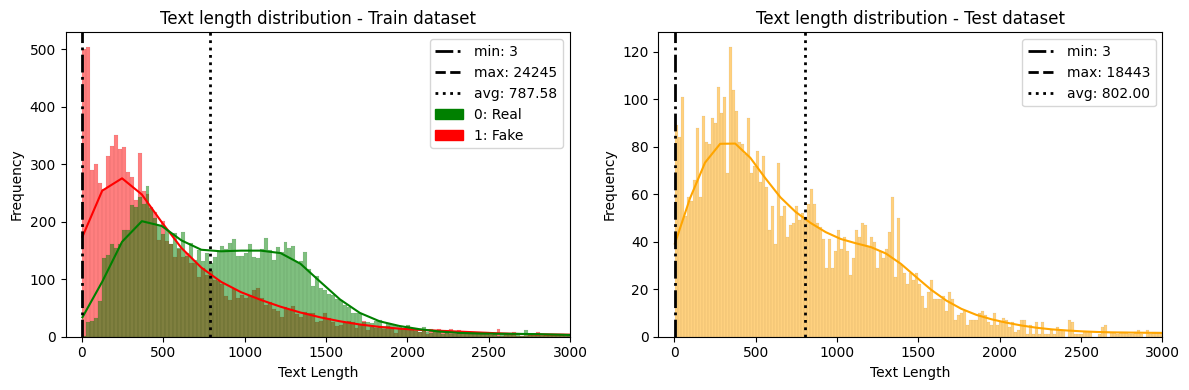

In [ ]:
import matplotlib.patches as mpatches

train_avg_length = sum(df_train_num_tokens["token_length"]) / len(df_train_num_tokens["token_length"])
train_max_length = max(df_train_num_tokens["token_length"])
train_min_length = min(df_train_num_tokens["token_length"])

test_avg_length = int(sum(test_num_tokens["test"]) / len(test_num_tokens["test"]))
test_max_length = max(test_num_tokens["test"])
test_min_length = min(test_num_tokens["test"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

colors_label = {0: "green", 1: "red"}
patch_label_0 = mpatches.Patch(color="green", label="0: Real")
patch_label_1 = mpatches.Patch(color="red", label="1: Fake")

sns.histplot(data = df_train_num_tokens, x = "token_length", kde=True, bins=1000, ax=axes[0], hue = "label", palette=colors_label)
axes[0].axvline(train_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_min_length}')
axes[0].axvline(train_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_max_length}')
axes[0].axvline(train_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_avg_length:.2f}')
axes[0].set_title("Text length distribution - Train dataset")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-100, 3000)
handles, labels = axes[0].get_legend_handles_labels()
handles.extend([patch_label_0, patch_label_1])
axes[0].legend(handles=handles)

sns.histplot(test_num_tokens["test"], kde=True, color="orange", bins=1000, ax=axes[1])
axes[1].axvline(test_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {test_min_length}')
axes[1].axvline(test_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {test_max_length}')
axes[1].axvline(test_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {test_avg_length:.2f}')
axes[1].set_title("Text length distribution - Test dataset")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(-100, 3000)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
stats_label_0 = df_train_num_tokens.query("label == 0").describe()
stats_label_1 = df_train_num_tokens.query("label == 1").describe()

pd.concat([stats_label_0, stats_label_1], axis=1)

,label,token_length,label,token_length
count,10387.0,10387.000000,10413.0,10413.000000
mean,0.0,923.974295,1.0,651.528762
std,0.0,766.173310,0.0,965.746526
min,0.0,13.000000,1.0,3.000000
25%,0.0,431.000000,1.0,185.000000
50%,0.0,816.000000,1.0,397.000000
75%,0.0,1234.000000,1.0,803.000000
max,0.0,15283.000000,1.0,24245.000000


In [ ]:
from nltk.probability import FreqDist
train_df_words = pd.DataFrame({"input_text": train["input_text"], "label": train["label"]})
tokens_label_0 = [token for i, lista_tokens in enumerate(train_df_words['input_text'])
                  if train_df_words['label'].iloc[i] == 0 for token in list(lista_tokens.split(" "))]
tokens_label_1 = [token for i, lista_tokens in enumerate(train_df_words['input_text'])
                  if train_df_words['label'].iloc[i] == 1 for token in list(lista_tokens.split(" "))]

fdist_label_0 = FreqDist(tokens_label_0)
fdist_label_1 = FreqDist(tokens_label_1)

In [ ]:
print("Most frequent words real news:")
fdist_label_0.most_common(10)

Most frequent words real news:


[('the', 477786),
 ('', 297406),
 ('to', 245507),
 ('of', 238936),
 ('a', 221848),
 ('and', 206978),
 ('in', 173291),
 ('that', 114656),
 ('for', 82760),
 ('on', 77853)]

In [ ]:
print("Most frequent words fake news:")
fdist_label_1.most_common(10)

Most frequent words fake news:


[('the', 338838),
 ('of', 178441),
 ('to', 177388),
 ('and', 157253),
 ('a', 123307),
 ('in', 108568),
 ('that', 81339),
 ('is', 78508),
 ('for', 54773),
 ('on', 45013)]

## Cleaning data

In [ ]:
# Split train dataset (train, val, test)

original_train = train.copy()
train = train[["input_text", "label"]]

train_size = int(0.9 * len(train))
train_df = train[:train_size]
test_df = train[train_size:]

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data, train_label, val_label = train_test_split(train_df['input_text'], train_df['label'],
                                                                    random_state=1108,
                                                                    test_size=0.3,
                                                                    shuffle=False)

test_data, test_label = test_df["input_text"], test_df['label']
test_data_submission = test['input_text']

print('Train dataset: ', train_data.shape)
print('Validation dataset: ', val_data.shape)
print('Test dataset: ', test_data.shape)
print('Test dataset submission Kaggle: ', test_data_submission.shape)

Train dataset:  (13104,)
Validation dataset:  (5616,)
Test dataset:  (2080,)
Test dataset submission Kaggle:  (5200,)


In [ ]:
import nltk
import re

import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lowercasing_text(input_text):
    input_text = input_text.apply(lambda x: x.lower())
    return input_text

def words_contractions_processing(input_text):
    try:
        input_text = input_text.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
    except:
        None
    return input_text

def remove_numeric_values(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'\d+', ' ', x))
    return input_text

def remove_punctuation(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    return input_text

def remove_line_break(input_text):
    input_text = input_text.apply(lambda x: x.replace("\n", " "))
    return input_text

def english_vocabulary(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'[^a-z]+', ' ', x))
    return input_text

def remove_spaces_between_words(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'\s+', ' ', x))
    return input_text

# Lemmatization functions
def nltkToWordnet(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatize a list of words/tokens
def lemmatize(tokens):
    pos_tags = nltk.pos_tag(tokens)
    res_words = []
    for word, tag in pos_tags:
        tag = nltkToWordnet(tag)
        if tag is None:
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return res_words

def lemmatization_stopwords_removal(input_text):
    input_text = input_text.apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    input_text = input_text.apply(lambda x: lemmatize(x))
    input_text =  input_text.apply(lambda x: [word for word in x if word not in stop_words])
    input_text = input_text.apply(" ".join)
    return input_text

In [ ]:
def preprocessing_news(data):
    data = lowercasing_text(data)
    data = words_contractions_processing(data)
    data = remove_numeric_values(data)
    data = remove_punctuation(data)
    data = remove_line_break(data)
    data = english_vocabulary(data)
    data = remove_spaces_between_words(data)
    data = lemmatization_stopwords_removal(data)
    return data

In [ ]:
import datetime

ini = datetime.datetime.now()
train_data = preprocessing_news(train_data)
val_data = preprocessing_news(val_data)
test_data = preprocessing_news(test_data)
test_data_submission = preprocessing_news(test_data_submission)
end = datetime.datetime.now()

print('Duration cleaning data: ' , end-ini)

Duration cleaning data:  0:14:20.890056


In [ ]:
df_train_clean = pd.DataFrame({"input_text": train_data, "label": train_label})
train_clean_num_tokens = get_token_counts(df_train_clean)

train_clean_avg_length = (sum(train_clean_num_tokens[1]) + sum(train_clean_num_tokens[0]))/(len(train_clean_num_tokens[1]) + len(train_clean_num_tokens[0]))
train_clean_max_length = max(max(train_clean_num_tokens[1]),max(train_clean_num_tokens[1]))
train_clean_min_length = min(min(train_clean_num_tokens[1]),min(train_clean_num_tokens[1]))

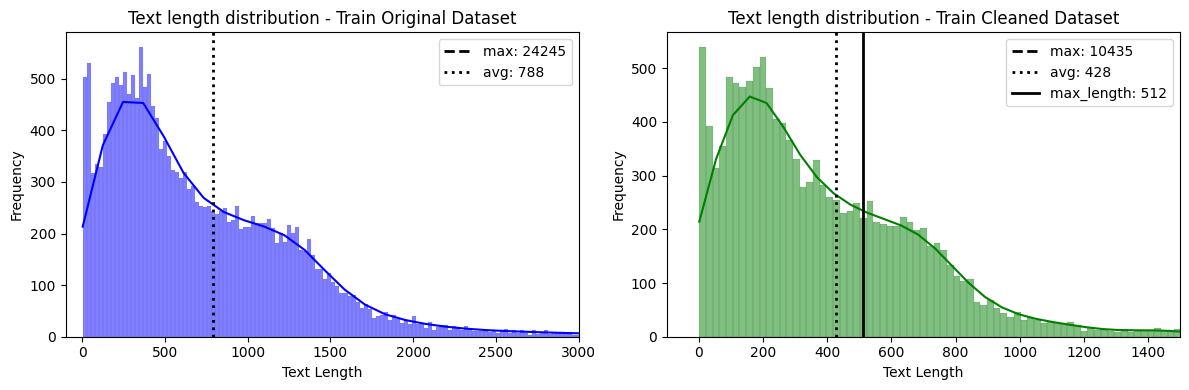

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data = df_train_num_tokens, x = "token_length", kde=True, color="blue", bins=1000, ax=axes[0])
# axes[0].axvline(train_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_min_length}')
axes[0].axvline(train_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_max_length}')
axes[0].axvline(train_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_avg_length:.0f}')
axes[0].set_title("Text length distribution - Train Original Dataset")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-100, 3000)
axes[0].legend()

sns.histplot(train_clean_num_tokens[0]+train_clean_num_tokens[1], kde=True, color="green", bins=500, ax=axes[1])
# axes[1].axvline(train_clean_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_clean_min_length}')
axes[1].axvline(train_clean_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_clean_max_length}')
axes[1].axvline(train_clean_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_clean_avg_length:.0f}')
axes[1].axvline(512, color='black', linewidth=2, label=f'max_length: {512:.0f}')
axes[1].set_title("Text length distribution - Train Cleaned Dataset")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(-100, 1500)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
df_train_clean_num_tokens = pd.concat([pd.DataFrame({"label": 0, "token_length": train_clean_num_tokens[0]}), pd.DataFrame({"label": 1, "token_length": train_clean_num_tokens[1]})])

stats_train_original = df_train_num_tokens.describe()
stats_train_clean = df_train_clean_num_tokens.describe()

df_concat_stats = pd.concat([stats_train_original, stats_train_clean], axis=1)
df_concat_stats.columns = [["label1","token_length_train_original","label2", "token_length_train_cleaned"]]

In [ ]:
df_concat_stats[["token_length_train_original", "token_length_train_cleaned"]]

,token_length_train_original,token_length_train_cleaned
count,20800.000000,13104.000000
mean,787.581250,427.825092
std,882.372346,467.283184
min,3.000000,1.000000
25%,286.000000,157.000000
50%,580.000000,318.500000
75%,1086.000000,588.250000
max,24245.000000,10435.000000


In [ ]:
train_data_words = pd.DataFrame({"input_text": train_data, "label": train_label})

train_tokens_label_0 = [token for i, lista_tokens in enumerate(train_data_words['input_text'])
                  if train_data_words['label'].iloc[i] == 0 for token in list(lista_tokens.split(" "))]
train_tokens_label_1 = [token for i, lista_tokens in enumerate(train_data_words['input_text'])
                  if train_data_words['label'].iloc[i] == 1 for token in list(lista_tokens.split(" "))]

fdist_label_0 = FreqDist(train_tokens_label_0)
fdist_label_1 = FreqDist(train_tokens_label_1)

In [ ]:
print("Most frequent words real news:")
fdist_label_0.most_common(10)

Most frequent words real news:


[('say', 52278),
 ('mr', 41817),
 ('trump', 23268),
 ('new', 16737),
 ('would', 15957),
 ('state', 15655),
 ('time', 15336),
 ('one', 14945),
 ('year', 13784),
 ('people', 12886)]

In [ ]:
print("Most frequent words fake news:")
fdist_label_1.most_common(10)

Most frequent words fake news:


[('clinton', 13154),
 ('say', 13151),
 ('trump', 12764),
 ('people', 10889),
 ('would', 10616),
 ('one', 10536),
 ('state', 10465),
 ('us', 9879),
 ('hillary', 8391),
 ('go', 8298)]

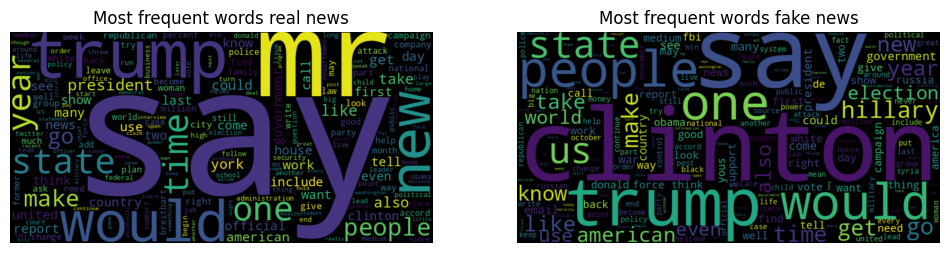

In [ ]:
from wordcloud import WordCloud

wordcloud_label_0 = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(fdist_label_0)
wordcloud_label_1 = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(fdist_label_1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.title('Most frequent words real news')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.title('Most frequent words fake news')
plt.axis('off')

plt.show()

In [ ]:
import numpy as np

data_array = np.array(train_clean_num_tokens[0] + train_clean_num_tokens[1])
limit_tokens = np.sum(data_array <= 512)
print(f"{(limit_tokens / len(data_array))*100:.0f}% of the news have less than or equal to 512 tokens")

69% of the news have less than or equal to 512 tokens


# **Train roBERTa Tensorflow model with Keras**

In [ ]:
import numpy as np

In [ ]:
max_length = 512
transformer_model = "roberta-base"

## Tokenization

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
tokenizer

RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:
tokenized_train = tokenizer(train_data.to_list(), return_tensors="np", truncation = True, padding=True, max_length = max_length)
tokenized_val = tokenizer(val_data.to_list(), return_tensors="np", truncation = True, padding=True, max_length = max_length)
tokenized_test = tokenizer(test_data.to_list(), return_tensors="np",truncation = True, padding=True, max_length = max_length)

In [ ]:
tokenized_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
dict(tokenized_train)

{'input_ids': array([[    0,   417, 29817, ...,  5318,  2737,     2],
        [    0,   417, 35947, ...,     1,     1,     1],
        [    0, 10998, 48629, ...,  1692,  3204,     2],
        ...,
        [    0,  3204,   428, ...,     1,     1,     1],
        [    0,  2001,   642, ...,     1,     1,     1],
        [    0,   267,  1728, ...,  5478,   232,     2]]),
 'attention_mask': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1]])}

In [ ]:
train_label_np = np.array(train_label)
val_label_np = np.array(val_label)
test_label_np = np.array(test_label)

In [ ]:
print(train_label_np)

[1 0 1 ... 1 1 0]


## Training

In [ ]:
import tensorflow as tf

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
print(tokenized_train["input_ids"][0])

[    0   417 29817 23478   687   790  4410  9498   190   192   283  2459
  1601  1236 12231  1855  3707 13126  3545   790  4410  9498   190   192
   283  2459  1601  1236 12231  1855  3707 13126  3545   385 29817 23478
   687 16874 24761 11222  1236 12231  1855  3707 13126 33062 38187   260
 20935 16080   895  2274  7676   475 25554  1236  1168   607   577  3904
 39758  1409  4385  9664  7321  3432 22796  1943  4621  2980  1099   621
   232   186   506  5605   736  1236 12336   283   219 10170   790  7368
  9498   356   101    67   216   200 24390   621   157  1004   283   219
  2142   122  9433 30681  1601  4659   856  5605   356  1047   189 12155
  9910  1766  3741 10528  1047 10228  7141 26232  4249  1540  1798   283
   219   465  1241  3545    65 37958  1540  2243   216   283   219 18981
 37958  2243  7368  7938   919   790  2316 13756  9233  1540  1218  1551
  1047   682  8286   645   192  5585 36029   335   251  1601   213  9233
  1540  2243  1236 12231  1855  3707 13126   278   

In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.layers

In [ ]:
ini = datetime.datetime.now()

model.fit(dict(tokenized_train),
          train_label_np,
          validation_data=(dict(tokenized_val), val_label_np),
          batch_size=12,
          epochs=3)

end = datetime.datetime.now()

print('Duration training loop: ' , end-ini)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1092/1092 [==============================] - 629s 506ms/step - loss: 0.6945 - accuracy: 0.5141 - val_loss: 0.6933 - val_accuracy: 0.4959
Epoch 2/3
1092/1092 [==============================] - 541s 495ms/step - loss: 0.6959 - accuracy: 0.5012 - val_loss: 0.6951 - val_accuracy: 0.4959
Epoch 3/3
1092/1092 [==============================] - 540s 495ms/step - loss: 0.6960 - accuracy: 0.4937 - val_loss: 0.7102 - val_accuracy: 0.5041
Duration training loop:  0:28:30.294315


## Improve training performance

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

batch_size = 12
num_epochs = 3

num_train_steps = (len(train_label_np)/batch_size) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate = lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
del model # Drop previous model

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import datetime
ini = datetime.datetime.now()

model.fit(dict(tokenized_train),
          train_label_np,
          validation_data=(dict(tokenized_val), val_label_np),
          batch_size=12,
          epochs=3)

end = datetime.datetime.now()

print('Duration training loop: ' , end-ini)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1092/1092 [==============================] - 639s 511ms/step - loss: 0.2415 - accuracy: 0.9021 - val_loss: 0.3167 - val_accuracy: 0.9491
Epoch 2/3
1092/1092 [==============================] - 547s 501ms/step - loss: 0.0959 - accuracy: 0.9722 - val_loss: 0.0494 - val_accuracy: 0.9849
Epoch 3/3
1092/1092 [==============================] - 547s 501ms/step - loss: 0.0342 - accuracy: 0.9901 - val_loss: 0.0430 - val_accuracy: 0.9868
Duration training loop:  0:28:54.048291


## Evaluation

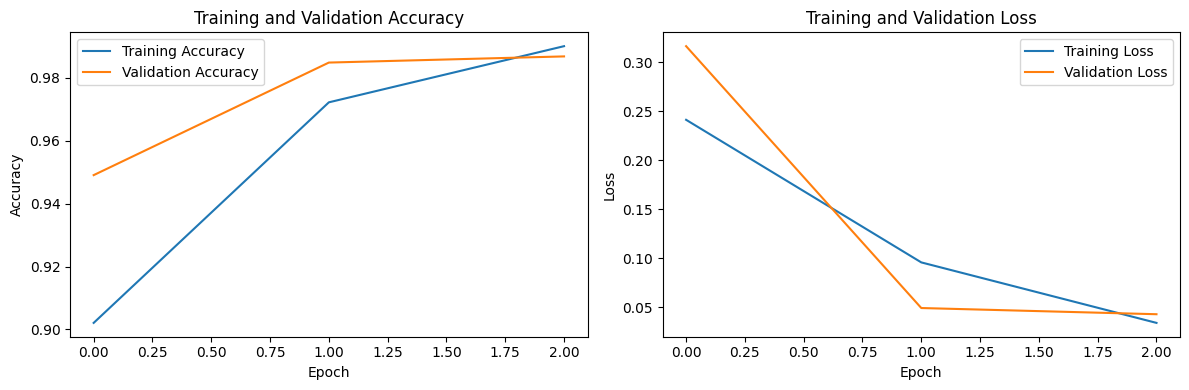

In [ ]:
history_plt = model.history.history

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history_plt['accuracy'], label='Training Accuracy')
axs[0].plot(history_plt['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history_plt['loss'], label='Training Loss')
axs[1].plot(history_plt['val_loss'], label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
print('Train Accuracy: ',model.history.history["accuracy"][2])
print('Validation Accuracy: ',model.history.history["val_accuracy"][2])

Train Accuracy:  0.9900793433189392
Validation Accuracy:  0.9868233799934387


## Prediction

### Test Dataset

In [ ]:
preds = model.predict(dict(tokenized_test))

65/65 [==============================] - 30s 351ms/step


In [ ]:
preds

TFSequenceClassifierOutput(loss=None, logits=array([[-3.5979183,  3.577199 ],
       [ 3.4332423, -3.5228686],
       [-3.5635314,  3.5154977],
       ...,
       [ 3.496493 , -3.5802984],
       [-3.3814936,  3.287443 ],
       [-2.6040363,  2.3512151]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
predictions = np.argmax(preds["logits"], axis=1)

In [ ]:
predictions

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

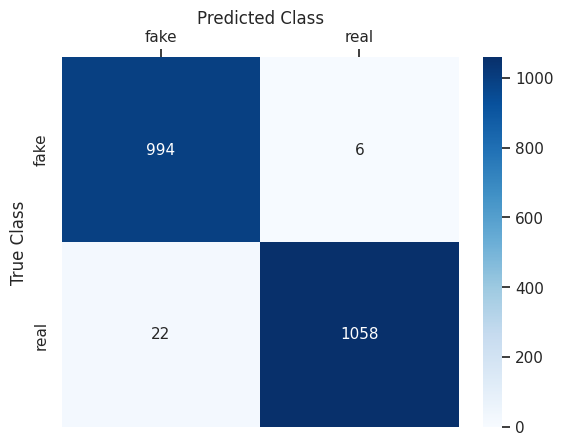

              precision    recall  f1-score   support

        fake     0.9783    0.9940    0.9861      1000
        real     0.9944    0.9796    0.9869      1080

    accuracy                         0.9865      2080
   macro avg     0.9864    0.9868    0.9865      2080
weighted avg     0.9867    0.9865    0.9865      2080



In [ ]:
confusion = confusion_matrix(np.array(test_label), predictions)

# plot confusion matrix
sns.set(font_scale=1.0)
labels = ["fake", "real"]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11}, fmt='d', vmin = 0, cmap='Blues', yticklabels=labels, xticklabels=labels)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(np.array(test_label), predictions, digits = 4, output_dict=False, target_names=["fake", "real"],)
print(report)

### Test Dataset Kaggle (Submission)

In [ ]:
test_data_submission

0       david streitfeld specter trump loosens tongue ...
1       russian warship ready strike terrorist near al...
2       common dream nodapl native american leader vow...
3       daniel victor tim tebow attempt another comeba...
4       truth broadcast network keiser report meme war...
                              ...                        
5195    jody rosen bangladeshi traffic jam never end n...
5196    sheryl gay stolberg john kasich sign one abort...
5197    mike mcphate california today exactly sushi ne...
5198    us marine deploy russian border norway previou...
5199    teddy wayne awkward sex onscreen new york time...
Name: input_text, Length: 5200, dtype: object

In [ ]:
tokenized_test_data_sub = tokenizer(test_data_submission.to_list(), return_tensors="np",truncation = True, padding=True, max_length = max_length)

In [ ]:
tokenized_test_data_sub

{'input_ids': array([[    0,   417, 23656, ...,    74, 17534,     2],
       [    0,   338, 42472, ...,     1,     1,     1],
       [    0, 27278,  3366, ...,   101,  8636,     2],
       ...,
       [    0,   119,  4348, ...,  2366,  4675,     2],
       [    0,   687,  9580, ...,     1,     1,     1],
       [    0,  5357,  7180, ...,   898, 14324,     2]]), 'attention_mask': array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])}

In [ ]:
preds_sub = model.predict(dict(tokenized_test_data_sub))

163/163 [==============================] - 70s 376ms/step


In [ ]:
predictions_sub = np.argmax(preds_sub["logits"], axis=1)

In [ ]:
predictions_sub

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
kaggle_results = pd.DataFrame({"id": test["id"],"label":predictions_sub})
kaggle_results.to_csv("/content/drive/MyDrive/Colab Notebooks/TFM/roberta_fineTune.csv", index=False)

In [ ]:
kaggle_results

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1


## Save Model

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/TFM/roberta_base_model_ft_weights")

In [ ]:
model_loaded = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
model_loaded.load_weights("/content/drive/MyDrive/Colab Notebooks/TFM/roberta_base_model_ft_weights")

In [ ]:
model_loaded.summary()

Model: "tf_roberta_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
text_news = """
Trump taps federal appeals court Judge Brett Kavanaugh for Supreme Court
WASHINGTON — President Donald Trump on Monday nominated Brett Kavanaugh, a federal appeals court judge in Washington, to succeed Justice Anthony Kennedy on the Supreme Court.
Trump made the announcement shortly after 9 p.m. ET at the White House, where he was joined by Kavanaugh and his family. NBC News broke the story shortly before the president made his choice public.
"What matters is not a judge's personal views, but whether they can set aside those views to do what the law and the Constitution require," Trump said in the prime-time announcement from the East Room. "I am pleased to say I have found, without doubt, such a person."
"It is my my honor to announce that I will nominate that I will nominate Justice Brett Kavanaugh to the United States Supreme Court," Trump added.
Kavanaugh then emerged, along with his wife, Ashley, and two young daughters.
Trump praised his nominee as a judge with "impeccable credentials" and said he is "considered a judge’s judge."
"""
text_news_prep = preprocessing_news(pd.Series(text_news))

In [ ]:
token_text_news = tokenizer(text_news_prep.to_list(), return_tensors="np",truncation = True, padding=True, max_length = max_length)

In [ ]:
from transformers import AutoTokenizer
tokenizer_model = AutoTokenizer.from_pretrained("roberta-base")
tokenized_news = tokenizer_model(text_news_prep.tolist(), truncation=True, padding=True, max_length=512, return_tensors="np")

In [ ]:
tokenized_news

{'input_ids': array([[    0, 38060,  5797,   752,  2868,   461,  1679, 15549,  5967,
          449, 39761, 15835,   461, 14784,  1054,   394,   218,  5618,
        20125,   475, 46328, 22159, 15549,  5967,   449, 39761,   752,
         2868,   461,  1679, 14784,  1054,  6726,  2427, 38631,  6119,
          449,  4734, 14425, 15835,   461, 20125,   146,  2443,  3691,
         4751,  4400,  1104,   790,  1962,   449, 39761,   284,   295,
        23219,   340,  1108,   527,  3691,   394,   146,  2031,   285,
          948,  1679,  1081,  1217,   549,   278,  4364,  1217,   488,
         7255,  2703, 20125,   224,  9156, 16093,  2443,  3017,   929,
         4343,   224,   465,   396,  2980,   621,  3712,  4659, 22159,
        22159,  2427, 15549,  5967,   449, 39761, 10409,   194, 15835,
          461, 20125,  1606,   449, 39761,  9845,   552,  1141, 14016,
          607,    80,   664,  1354, 20125,  8249,  6615,  1679, 28462,
          868, 37440,   224,  1701,  1679,  1679,     2]]), 'at

In [ ]:
preds_news = model_loaded.predict(dict(tokenized_news))

1/1 [==============================] - 10s 10s/step


In [ ]:
if preds_news["logits"].argmax(-1) == [1]:
  # print(text_news)
  print("Is a Fake News")
else:
  # print(text_news)
  print("Is a Real News")

Is a Real News
